Processed AB_3_1018.xml -> suffix 1018: D=0.2335 in, area=0.04282 in^2, total points=3899, cut_idx=3894
Processed AB_3_1045.xml -> suffix 1045: D=0.2400 in, area=0.04524 in^2, total points=4005, cut_idx=3999
Processed AB_3_6061.xml -> suffix 6061: D=0.2470 in, area=0.04792 in^2, total points=3740, cut_idx=3720


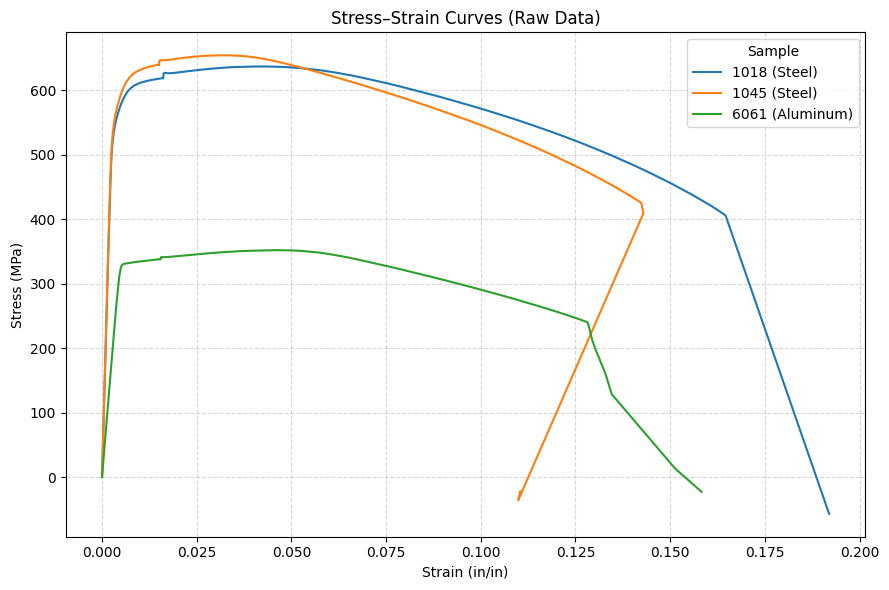

/tmp/ipykernel_22438/688449982.py:72: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  resilience = np.trapz(stress[:idx+1], strain[:idx+1])
/tmp/ipykernel_22438/688449982.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  toughness = np.trapz(stress, strain)


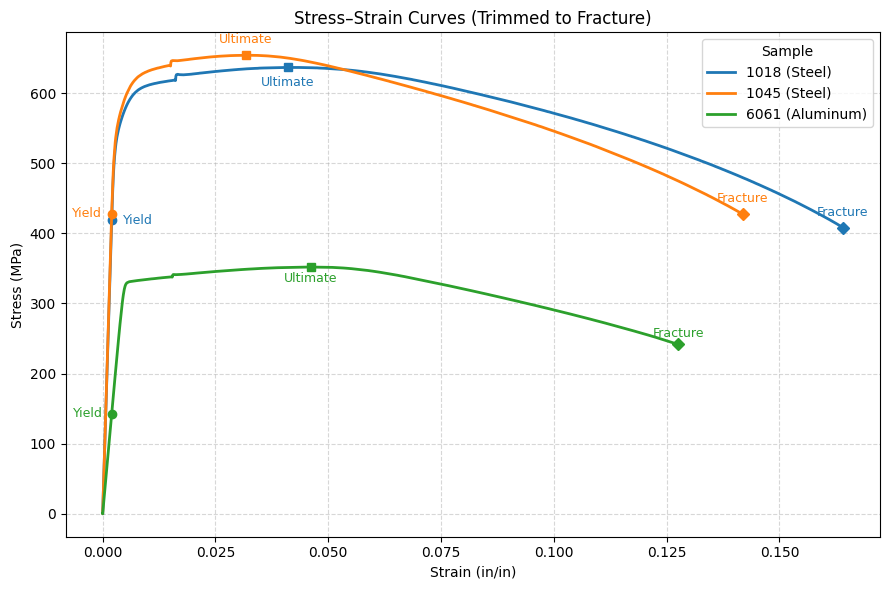

,Sample,Material,E (GPa),Yield Stress (MPa),Yield Strain,Ultimate Stress (MPa),Ultimate Strain,Fracture Stress (MPa),Fracture Strain,Resilience (MJ/m³),Toughness (MJ/m³)
0,1018,Steel,208.5,418.5,0.0020,636.5,0.0411,407.9,0.1641,0.419,92.697
1,1045,Steel,215.7,427.7,0.0020,653.8,0.0318,427.3,0.1419,0.429,81.385
2,6061,Aluminum,71.1,142.6,0.0020,351.9,0.0462,241.4,0.1276,0.143,40.061



✓ Table exported to: mechanical_properties_summary.csv


In [2]:
# ===============================================================
# FULL SCRIPT: RAW + TRIMMED STRESS-STRAIN PLOTS WITH LABELS
# ===============================================================

import xml.etree.ElementTree as ET
import os, re, math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ---------- USER EDITABLE ----------
file_names = ["AB_3_1018.xml", "AB_3_1045.xml", "AB_3_6061.xml"]
D_values = {"1018": 0.2335, "1045": 0.24, "6061": 0.247}
l_0 = 1.0
GAUGE_LENGTH_MM = l_0 * 25.4
material_map = {"1018": "Steel", "1045": "Steel", "6061": "Aluminum"}

# ---------- FUNCTIONS ----------
def extract_arrays(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    data = {}
    for var in root.iter("VariableData"):
        name = var.find("Name").text.strip()
        vals = [float(v.text) for v in var.find("Values").findall("Value")]
        if name == "_TimeArray": data["time"] = vals
        elif name == "_LoadArray": data["load"] = vals
        elif name == "_Strain1Array": data["strain"] = vals
    return data

def find_fracture_index_adaptive(stress, strain):
    if len(stress) < 5: return len(stress)
    stress, strain = np.array(stress), np.array(strain)
    peak_idx = int(np.argmax(stress))
    max_stress = stress[peak_idx]
    n = len(stress)
    window = 5
    rel_drop_thresh = 0.05
    for i in range(peak_idx, n - window):
        future = stress[i + 1 : i + 1 + window]
        if len(future) < window: break
        drop = (stress[i] - np.min(future)) / max_stress
        if drop >= rel_drop_thresh:
            if np.all(np.diff(stress[i:i+window+1]) <= 0.02*max_stress) or np.min(future) < 0.9*max_stress:
                return i + 1
    k = 8
    for i in range(peak_idx, n - k):
        segment = stress[i:i+k]
        if np.mean(np.diff(segment)) < -0.002*max_stress: return i + 1
    low_thresh = 0.1*max_stress
    valid_idxs = np.where(stress > low_thresh)[0]
    if len(valid_idxs) > 0: return min(valid_idxs[-1]+1, n)
    return n

def mechanical_properties(strain, stress, material_type):
    strain, stress = np.array(strain), np.array(stress)
    ultimate_stress = np.max(stress)
    ultimate_strain = strain[np.argmax(stress)]
    fracture_stress = stress[-1]
    fracture_strain = strain[-1]
    elastic_stress_limit = 400 if material_type=="Steel" else 200
    elastic_mask = (strain<0.003) & (stress<elastic_stress_limit) & (stress>10)
    if np.sum(elastic_mask) > 5:
        E,_ = np.polyfit(strain[elastic_mask], stress[elastic_mask], 1)
    else: E,_ = np.polyfit(strain[:20], stress[:20],1)
    offset = 0.002
    offset_line = E*(strain-offset)
    search_start = np.argmin(np.abs(strain-0.002))
    crossing = np.where(stress[search_start:] >= offset_line[search_start:])[0]
    idx = search_start + crossing[0] if len(crossing)>0 else np.argmin(np.abs(strain-offset))
    yield_stress, yield_strain = stress[idx], strain[idx]
    resilience = np.trapz(stress[:idx+1], strain[:idx+1])
    toughness = np.trapz(stress, strain)
    return {
        "Fracture (ε,σ)": (fracture_strain, fracture_stress),
        "Ultimate (ε,σ)": (ultimate_strain, ultimate_stress),
        "Yield (ε,σ)": (yield_strain, yield_stress),
        "E (GPa)": E/1000,
        "Resilience (MJ/m³)": resilience,
        "Toughness (MJ/m³)": toughness
    }

# ===============================================================
# PROCESS FILES AND STORE ARRAYS
# ===============================================================
processed_suffixes = []
for i, file in enumerate(sorted(file_names)):
    match = re.search(r"(\d{4})", file)
    suffix = match.group(1) if match else str(i)
    processed_suffixes.append(suffix)
    arr = extract_arrays(file)
    time_arr = np.array(arr.get("time",[]))
    load_arr = np.array(arr.get("load",[]))
    strain_arr = np.array(arr.get("strain",[])) / GAUGE_LENGTH_MM
    load_N = load_arr*1000
    D_in = D_values.get(suffix, list(D_values.values())[0])
    A_in2 = math.pi*(D_in**2)/4.0
    A_m2 = A_in2*(0.0254**2)
    stress_Pa = load_N/A_m2
    stress_MPa = stress_Pa/1e6
    cut_idx = find_fracture_index_adaptive(stress_MPa, strain_arr)
    if cut_idx <= 1: cut_idx = len(stress_MPa)
    globals()[f"time_{suffix}"] = time_arr
    globals()[f"load_{suffix}"] = load_arr
    globals()[f"strain_{suffix}"] = strain_arr
    globals()[f"stress_{suffix}"] = stress_MPa
    globals()[f"D_{suffix}"] = D_in
    globals()[f"A_{suffix}"] = A_in2
    globals()[f"cut_idx_{suffix}"] = cut_idx
    print(f"Processed {file} -> suffix {suffix}: D={D_in:.4f} in, area={A_in2:.5f} in^2, total points={len(stress_MPa)}, cut_idx={cut_idx}")

# ===============================================================
# PLOT RAW DATA (FIRST FIGURE)
# ===============================================================
plt.figure(figsize=(9,6))
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple"]
for i, suffix in enumerate(processed_suffixes):
    strain = globals()[f"strain_{suffix}"]
    stress = globals()[f"stress_{suffix}"]
    mat_type = material_map.get(suffix,"Unknown")
    plt.plot(strain, stress, label=f"{suffix} ({mat_type})", color=colors[i%len(colors)], linewidth=1.5)
plt.title("Stress–Strain Curves (Raw Data)")
plt.xlabel("Strain (in/in)")
plt.ylabel("Stress (MPa)")
plt.grid(ls="--", alpha=0.5)
plt.legend(title="Sample")
plt.tight_layout()
plt.show()

# ===============================================================
# PLOT TRIMMED DATA WITH LABELED POINTS
# ===============================================================
plt.figure(figsize=(9,6))
yield_positions, ultimate_positions = [], []
for suffix in processed_suffixes:
    strain = globals()[f"strain_{suffix}"][:globals()[f"cut_idx_{suffix}"]]
    stress = globals()[f"stress_{suffix}"][:globals()[f"cut_idx_{suffix}"]]
    mat_type = material_map.get(suffix,"Unknown")
    props = mechanical_properties(strain, stress, mat_type)
    yield_positions.append((suffix, props["Yield (ε,σ)"][0], props["Yield (ε,σ)"][1]))
    ultimate_positions.append((suffix, props["Ultimate (ε,σ)"][0], props["Ultimate (ε,σ)"][1]))

median_yield_x = np.median([yp[1] for yp in yield_positions])
median_ult_y = np.median([up[2] for up in ultimate_positions])

for i, suffix in enumerate(processed_suffixes):
    strain = globals()[f"strain_{suffix}"][:globals()[f"cut_idx_{suffix}"]]
    stress = globals()[f"stress_{suffix}"][:globals()[f"cut_idx_{suffix}"]]
    mat_type = material_map.get(suffix,"Unknown")
    props = mechanical_properties(strain, stress, mat_type)
    plt.plot(strain, stress, label=f"{suffix} ({mat_type})", color=colors[i%len(colors)], linewidth=2)
    offset_x = max(strain)*0.015
    offset_y = max(stress)*0.02

    # Yield
    yld_strain, yld_stress = props["Yield (ε,σ)"]
    plt.plot(yld_strain, yld_stress, 'o', color=colors[i%len(colors)], markersize=6)
    if yld_strain > np.median([yp[1] for yp in yield_positions]):
        plt.text(yld_strain + offset_x, yld_stress, "Yield", fontsize=9, color=colors[i%len(colors)], ha="left", va="center")
    else:
        plt.text(yld_strain - offset_x, yld_stress, "Yield", fontsize=9, color=colors[i%len(colors)], ha="right", va="center")

    # Ultimate
    ult_strain, ult_stress = props["Ultimate (ε,σ)"]
    plt.plot(ult_strain, ult_stress, 's', color=colors[i%len(colors)], markersize=6)
    if ult_stress > np.median([up[2] for up in ultimate_positions]):
        plt.text(ult_strain, ult_stress + offset_y, "Ultimate", fontsize=9, color=colors[i%len(colors)], ha="center", va="bottom")
    else:
        plt.text(ult_strain, ult_stress - offset_y, "Ultimate", fontsize=9, color=colors[i%len(colors)], ha="center", va="top")

    # Fracture
    frac_strain, frac_stress = props["Fracture (ε,σ)"]
    plt.plot(frac_strain, frac_stress, 'D', color=colors[i%len(colors)], markersize=6)
    plt.text(frac_strain, frac_stress + offset_y, "Fracture", fontsize=9, color=colors[i%len(colors)], ha="center", va="bottom")

plt.title("Stress–Strain Curves (Trimmed to Fracture)")
plt.xlabel("Strain (in/in)")
plt.ylabel("Stress (MPa)")
plt.grid(ls="--", alpha=0.5)
plt.legend(title="Sample")
plt.tight_layout()
plt.show()

# ===============================================================
# GENERATE MECHANICAL PROPERTIES TABLE
# ===============================================================
records = []
for suffix in processed_suffixes:
    strain = globals()[f"strain_{suffix}"][:globals()[f"cut_idx_{suffix}"]]
    stress = globals()[f"stress_{suffix}"][:globals()[f"cut_idx_{suffix}"]]
    mat_type = material_map.get(suffix,"Unknown")
    props = mechanical_properties(strain, stress, mat_type)
    records.append({
        "Sample": suffix,
        "Material": mat_type,
        "E (GPa)": props["E (GPa)"],
        "Yield Stress (MPa)": props["Yield (ε,σ)"][1],
        "Yield Strain": props["Yield (ε,σ)"][0],
        "Ultimate Stress (MPa)": props["Ultimate (ε,σ)"][1],
        "Ultimate Strain": props["Ultimate (ε,σ)"][0],
        "Fracture Stress (MPa)": props["Fracture (ε,σ)"][1],
        "Fracture Strain": props["Fracture (ε,σ)"][0],
        "Resilience (MJ/m³)": props["Resilience (MJ/m³)"],
        "Toughness (MJ/m³)": props["Toughness (MJ/m³)"]
    })

df = pd.DataFrame(records)
pd.set_option('display.precision', 4)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.width', None)
display(df.style.set_caption("Mechanical Properties Summary")
       .set_table_styles([{'selector':'caption','props':[('caption-side','top'),('font-size','16px'),('font-weight','bold')]}])
       .format({
           "E (GPa)":"{:.1f}","Yield Stress (MPa)":"{:.1f}","Yield Strain":"{:.4f}",
           "Ultimate Stress (MPa)":"{:.1f}","Ultimate Strain":"{:.4f}",
           "Fracture Stress (MPa)":"{:.1f}","Fracture Strain":"{:.4f}",
           "Resilience (MJ/m³)":"{:.3f}","Toughness (MJ/m³)":"{:.3f}"
       }))
df.to_csv("mechanical_properties_summary.csv", index=False)
print("\n✓ Table exported to: mechanical_properties_summary.csv")
